In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [4]:
# Configuration
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [5]:
dataset_path = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.ckpt'
NUM_CLASSES = 4

In [6]:
# Load dataset
X = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, 21 * 2 + 1)))
y = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

In [8]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128)

In [9]:
from torchmetrics.classification import Accuracy


In [10]:
# Lightning module
class KeypointClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(21 * 2, 20),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, NUM_CLASSES)
        )
        self.accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [11]:
# Initialize model
model = KeypointClassifier()

In [12]:
# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='model/keypoint_classifier/',
    filename='keypoint_classifier',
    save_top_k=1,
    monitor='val_loss',
    mode='min'
)

In [13]:
# Trainer
trainer = pl.Trainer(
    max_epochs=1000,
    callbacks=[early_stop_callback, checkpoint_callback],
    deterministic=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
# Train the model
trainer.fit(model, train_loader, val_loader)

C:\Users\houci\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\houci\Documents\ENSAM\3eme annee\S6\Computer Vision\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier exists and is not empty.

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 1.1 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\houci\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 1.430


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 1.354


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 1.238


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.142


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.061


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.994


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.925


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.875


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.816


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.767


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.721


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.673


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.643


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.610


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.584


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.561


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.533


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.514


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.500


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.482


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.467


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.452


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.446


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.430


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.415


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.409


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.398


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.390


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.379


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.372


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.352


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.343


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.334


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.325


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.320


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.310


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.307


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.293


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.291


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.286


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.285


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.279


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.264


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.262


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.257


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.250


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.248


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.246


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.240


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.236


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.229


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.226


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.219


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.218


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.218


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.217


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.217


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.211


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.206


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.194


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.189


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.189


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.185


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.184


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.178


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.168


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.165


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.163


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.162


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.161


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.159


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.159


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.158


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.157


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.154


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.153


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.149


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.149. Signaling Trainer to stop.


In [15]:
# Load the best model
best_model = KeypointClassifier.load_from_checkpoint(model_save_path)

In [16]:
best_model.eval()
with torch.no_grad():
    test_sample = X_test_tensor[0].unsqueeze(0)
    output = best_model(test_sample)
    probs = torch.softmax(output, dim=1)
    print(probs.squeeze().numpy())
    print(torch.argmax(probs).item())

[9.7693676e-01 2.2950921e-02 1.0796577e-04 4.3683331e-06]
0


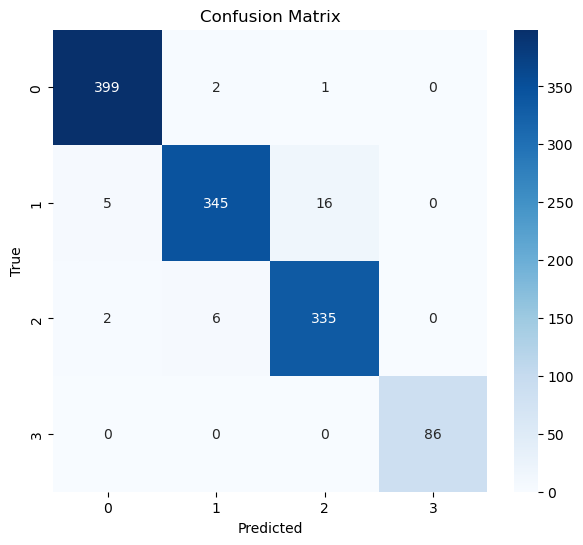

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       402
           1       0.98      0.94      0.96       366
           2       0.95      0.98      0.96       343
           3       1.00      1.00      1.00        86

    accuracy                           0.97      1197
   macro avg       0.98      0.98      0.98      1197
weighted avg       0.97      0.97      0.97      1197



In [17]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

# Set model to eval mode
model.eval()

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch prediction
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Collect predictions
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Plot confusion matrix and classification report
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, cmap='Blues')
    ax.set_ylim(len(labels), 0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

# Show results
print_confusion_matrix(all_targets, all_preds)


In [18]:
# Save only the weights
torch.save(model.state_dict(), "model/keypoint_classifier/keypoint_classifier_weights.pth")


In [20]:
from model.keypoint_classifier.keypoint_classifier_pyt import KeyPointClassifier

  # your model definition
import torch

# Rebuild the model architecture
model = KeypointClassifier()

# Load the saved weights
model.load_state_dict(torch.load("model/keypoint_classifier/keypoint_classifier_weights.pth"))
model.eval()


# Prepare input tensor (e.g., one sample from X_test)
input_tensor = torch.tensor([X_test[0]], dtype=torch.float32)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probs).item()

# Output results
print(probs.numpy())
print(predicted_class)


[9.6317524e-01 3.6696795e-02 1.2192871e-04 6.1229466e-06]
0


C:\Users\houci\AppData\Local\Temp\ipykernel_4176\3493685169.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  input_tensor = torch.tensor([X_test[0]], dtype=torch.float32)
